I use CNN for impleentatiojn of encorder and decoder

In [2]:
import torch
from google.colab import drive

# Now you can call the mount function
drive.mount('/content/drive')

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Mounted at /content/drive


In [3]:
# Section 1: Preparation and Imports
# ----------------------------------
# Import necessary libraries and set up Google Drive access for data loading.

import os  # Module for interacting with the file system
from google.colab import drive  # Google Colab library to mount Google Drive
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import re
from io import open

# Mount Google Drive to access files
drive.mount('/content/drive')

# Define paths for data
corpus_name = "movie-corpus"
corpus = os.path.join("/content/drive/My Drive/Colab Notebooks/nlp_pro_babu/data", corpus_name)
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

# Check for GPU availability
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

# Special tokens
PAD_token = 0
SOS_token = 1
EOS_token = 2
UNK_token = 3




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Section 2: Vocabulary Class and Data Loading
# --------------------------------------------
# This section contains the Vocabulary class and data loading functions, used to read the corpus,
# build the vocabulary, and prepare the data for training.

# Vocabulary class to map words to indices
class Vocabulary:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK"}
        self.num_words = 4  # Starting count for special tokens

    def addSentence(self, sentence):
        # Add each word in the sentence to the vocabulary
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # Add a word to the vocabulary
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

# Function to normalize the input text by removing punctuations and making it lowercase
def normalize_input_text(text):
    text = text.lower().strip()
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    return text

# Function to read the vocabulary and pairs from a given file
def readVocs(datafile, corpus_name):
    print("Reading lines from formatted movie lines file...")
    lines = open(datafile, encoding='utf-8').read().strip().split('\n')
    pairs = [[normalize_input_text(s) for s in l.split('\t')] for l in lines]
    voc = Vocabulary(corpus_name)
    return voc, pairs

# Function to filter pairs that are too long
def filterPair(p, MAX_LENGTH=10):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Function to filter all pairs
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Function to load and prepare the data for training
def loadPrepareData(corpus, corpus_name, datafile):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print(f"Counted words: {voc.num_words}")
    return voc, pairs

# Load vocabulary and pairs
voc, pairs = loadPrepareData(corpus, corpus_name, datafile)

# Print some pairs for validation
print("\nSample pairs:")
for pair in pairs[:10]:
    print(pair)




Start preparing training data ...
Reading lines from formatted movie lines file...
Read 221282 sentence pairs
Trimmed to 72501 sentence pairs
Counting words...
Counted words: 19519

Sample pairs:
['they do to ', 'they do not ']
['she okay ', 'i hope so ']
['wow', 'let s go ']
['what good stuff ', ' the real you ']
[' the real you ', 'like my fear of wearing pastels ']
['do you listen to this crap ', 'what crap ']
['well no ', 'then that s all you had to say ']
['then that s all you had to say ', 'but']
['but', 'you always been this selfish ']
['have fun tonight ', 'tons']


In [5]:
# Section 3: Batch Preparation Functions
# --------------------------------------
# Functions to prepare batches of data, convert sentences to indices, and pad sequences.

def indexesFromSentence(voc, sentence):
    # Convert each word in the sentence to an index, using UNK_token if not found
    indices = [voc.word2index.get(word, UNK_token) for word in sentence.split(' ')]
    return indices + [EOS_token]  # Append EOS token

def zeroPadding(l, fillvalue=PAD_token):
    # Pad sequences in the batch to have equal lengths
    padded_tensor = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in l], batch_first=True, padding_value=fillvalue)
    return padded_tensor

def batch2TrainData(voc, pair_batch):
    # Prepare batches of input and target sequences
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(indexesFromSentence(voc, pair[0]))
        output_batch.append(indexesFromSentence(voc, pair[1]))
    inp = zeroPadding(input_batch)
    output = zeroPadding(output_batch)
    return inp, output

# Example batch for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_var, target_var = batches

# Print example batches
print("input_var:", input_var)
print("target_var:", target_var)




input_var: tensor([[2260,   82, 2116,   23,   64,  261,  717,    7,    2],
        [1286,  151,   51,  966,   79,   21,  444,    7,    2],
        [  23,  126,  151,  498,  116,   92,    7,    2,    0],
        [  11,   44,    6,   17,  127,    7,    2,    0,    0],
        [  69,  123,   23,  917,    7,    2,    0,    0,    0]])
target_var: tensor([[   79,    21,   244,   115,     7,     2,     0,     0,     0,     0],
        [ 1845,   102,    16,  8604,    11,    38,   102, 18193,     7,     2],
        [   18,  5031,   311,     7,     2,     0,     0,     0,     0,     0],
        [   74,    31,   817,  2689,     7,     2,     0,     0,     0,     0],
        [  185,   184,  2001, 18545,     7,     2,     0,     0,     0,     0]])


In [6]:
# Section 4: CNN Encoder and Decoder
# ----------------------------------
# This section defines the CNN-based encoder and decoder used for sequence-to-sequence modeling.

class CNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size=5, dropout=0.4):
        super(CNNEncoder, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, padding=2)
        self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, padding=2)
        self.conv3 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, padding=2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq).permute(0, 2, 1)  # Shape: (batch_size, hidden_size, seq_len)
        conv_out = F.relu(self.conv1(embedded))
        conv_out = self.dropout(F.relu(self.conv2(conv_out)))
        conv_out = F.relu(self.conv3(conv_out))
        return conv_out.permute(0, 2, 1)  # Shape: (batch_size, seq_len, hidden_size)

class CNNDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, kernel_size=5, dropout=0.4):
        super(CNNDecoder, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, padding=2)
        self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, padding=2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_step, encoder_output):
        if len(input_step.shape) == 1:
            input_step = input_step.unsqueeze(1)

        embedded = self.embedding(input_step).permute(0, 2, 1)
        conv_out = F.relu(self.conv1(embedded))
        conv_out = self.dropout(F.relu(self.conv2(conv_out)))
        output = self.fc(conv_out[:, :, -1])
        return output





In [8]:
# Section 5: Training the Model
# -----------------------------
# Define the training loop and train the model using the configured hyperparameters.

network_params = {
    'hidden_dim': 512,
    'learning_rate': 0.001,
    'dropout_rate': 0.3,
    'layers_num': 2,
    'gradient_clip': 5.0,
    'batch_dim': 64
}


hidden_dim = network_params['hidden_dim']
learning_rate = network_params['learning_rate']
dropout_rate = network_params['dropout_rate']
layers_num = network_params['layers_num']
gradient_clip = network_params['gradient_clip']
batch_dim = network_params['batch_dim']

# Instantiate models
encoder = CNNEncoder(input_size=voc.num_words, hidden_size=hidden_dim).to(device)
decoder = CNNDecoder(hidden_size=hidden_dim, output_size=voc.num_words).to(device)

# Define optimizers and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Section 5: Training the Model
# -----------------------------
# Define the training loop and train the model using the configured hyperparameters.

network_params = {
    'hidden_dim': 512,
    'learning_rate': 0.001,
    'dropout_rate': 0.3,
    'layers_num': 2,
    'gradient_clip': 5.0,
    'batch_dim': 64
}


hidden_dim = network_params['hidden_dim']
learning_rate = network_params['learning_rate']
dropout_rate = network_params['dropout_rate']
layers_num = network_params['layers_num']
gradient_clip = network_params['gradient_clip']
batch_dim = network_params['batch_dim']

# Instantiate models
encoder = CNNEncoder(input_size=voc.num_words, hidden_size=hidden_dim).to(device)
decoder = CNNDecoder(hidden_size=hidden_dim, output_size=voc.num_words).to(device)

# Define optimizers and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=10):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)

    encoder_output = encoder(input_variable)

    decoder_input = torch.tensor([SOS_token for _ in range(input_variable.size(0))], device=device).unsqueeze(1)

    all_decoder_outputs = []
    for _ in range(target_variable.size(1)):
        decoder_output = decoder(decoder_input, encoder_output)
        all_decoder_outputs.append(decoder_output)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach().unsqueeze(1)

    decoder_outputs = torch.stack(all_decoder_outputs, dim=1).view(-1, decoder_output.size(-1))
    target_variable = target_variable.view(-1)

    loss = criterion(decoder_outputs, target_variable)
    loss.backward()

    _ = nn.utils.clip_grad_norm_(encoder.parameters(), gradient_clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), gradient_clip)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

# Train the model
num_epochs = 1000
print_every = 50
for epoch in range(1, num_epochs + 1):
    input_variable, target_variable = batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_dim)])
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    if epoch % print_every == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.4f}")


Epoch: 50, Loss: 4.2195
Epoch: 100, Loss: 3.8090
Epoch: 150, Loss: 3.5416
Epoch: 200, Loss: 3.7120
Epoch: 250, Loss: 3.2811
Epoch: 300, Loss: 3.6530
Epoch: 350, Loss: 3.5625
Epoch: 400, Loss: 3.7965
Epoch: 450, Loss: 3.5603
Epoch: 500, Loss: 4.1061
Epoch: 550, Loss: 3.6313
Epoch: 600, Loss: 3.3302
Epoch: 650, Loss: 3.5210
Epoch: 700, Loss: 3.6433
Epoch: 750, Loss: 3.6023
Epoch: 800, Loss: 3.5588
Epoch: 850, Loss: 3.5855
Epoch: 900, Loss: 3.2775
Epoch: 950, Loss: 3.4463
Epoch: 1000, Loss: 3.2945


save model into /content/drive/My Drive/Colab Notebooks/nlp_pro_babu/models/alternate

In [9]:
import os

# Define the save directory path for model and configuration files
save_dir = "/content/drive/My Drive/Colab Notebooks/nlp_pro_babu/models/alternate"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Function to save the model and configuration
def save_checkpoint(encoder, decoder, encoder_optimizer, decoder_optimizer, voc, network_params, epoch, save_dir):
    checkpoint = {
        'epoch': epoch,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
        'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
        'voc_dict': voc.__dict__,  # Save the entire vocabulary state
        'network_params': network_params  # Save network hyperparameters
    }
    checkpoint_path = os.path.join(save_dir, 'chatbot_model_checkpoint.tar')
    torch.save(checkpoint, checkpoint_path)
    print(f"Model and configuration saved to {checkpoint_path}")

save_checkpoint(encoder, decoder, encoder_optimizer, decoder_optimizer, voc, network_params, epoch=num_epochs, save_dir=save_dir)


NameError: name 'num_epochs' is not defined

Load saved model

In [10]:
import torch
import os

# Define the load directory path for the model checkpoint
load_dir = "/content/drive/My Drive/Colab Notebooks/nlp_pro_babu/models/alternate"
checkpoint_path = os.path.join(load_dir, 'chatbot_model_checkpoint.tar')

# Function to load the model and configuration
def load_checkpoint(encoder, decoder, encoder_optimizer, decoder_optimizer, voc, network_params, checkpoint_path):
    # Load the checkpoint from the specified path
    checkpoint = torch.load(checkpoint_path)
    print(f"Loading checkpoint from {checkpoint_path}")

    # Load model and optimizer states
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])

    # Update vocabulary and network parameters
    voc.__dict__.update(checkpoint['voc_dict'])
    network_params.update(checkpoint['network_params'])

    # Retrieve the epoch number
    epoch = checkpoint['epoch']
    print(f"Model loaded successfully, starting from epoch {epoch}")

    return epoch  # Return the epoch to resume training

# Example call to load the checkpoint
# Assuming `encoder`, `decoder`, `encoder_optimizer`, `decoder_optimizer`, `voc`, and `network_params` have been defined
epoch = load_checkpoint(encoder, decoder, encoder_optimizer, decoder_optimizer, voc, network_params, checkpoint_path)


<ipython-input-10-982eeba131ee>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loading checkpoint from /content/drive/My Drive/Colab Notebooks/nlp_pro_babu/models/alternate/chatbot_model_checkpoint.tar
Model loaded successfully, starting from epoch 1000


Interactive Bot Using Beam Search Decoding

Beam search improves response diversity by considering multiple output paths. The following code implements an interactive chatbot session using beam search.

In [ ]:
# Check the vocabulary coverage
print(f"Vocabulary size: {voc.num_words}")
print("Sample words in vocabulary:", list(voc.word2index.keys())[:20])


Vocabulary size: 19519
Sample words in vocabulary: ['they', 'do', 'to', '', 'not', 'she', 'okay', 'i', 'hope', 'so', 'wow', 'let', 's', 'go', 'what', 'good', 'stuff', 'the', 'real', 'you']


In [ ]:
print(f"Vocabulary size (voc.num_words): {voc.num_words}")
print(f"Encoder embedding size: {encoder.embedding.num_embeddings}")
print(f"Decoder embedding size: {decoder.embedding.num_embeddings}")


Vocabulary size (voc.num_words): 19519
Encoder embedding size: 19519
Decoder embedding size: 19519


In [12]:

# Beam Search decoding function with input normalization
def beam_search_decode(encoder, decoder, sentence, voc, beam_width=3, max_length=10):
    # Normalize input sentence
    sentence = normalize_input_text(sentence)
    indexes_batch = [indexesFromSentence(voc, sentence)]
    input_batch = torch.LongTensor(indexes_batch).to(device)

    # Encode input
    encoder_output = encoder(input_batch)

    # Initialize variables for beam search
    decoder_input = torch.LongTensor([[SOS_token]]).to(device)
    sequences = [([decoder_input], 0.0)]

    for step in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            if seq[-1].item() == EOS_token:
                all_candidates.append((seq, score))
                continue

            # Decode the current sequence step
            decoder_output = decoder(seq[-1], encoder_output)
            log_probs, top_indices = torch.topk(decoder_output, beam_width)

            # Expand each candidate by the top beam_width next tokens
            for i in range(beam_width):
                next_token = top_indices[0, i].unsqueeze(0)
                new_seq = seq + [next_token]
                new_score = score - log_probs[0, i].item()
                all_candidates.append((new_seq, new_score))

        # Select the best sequences for the next step
        ordered = sorted(all_candidates, key=lambda x: x[1])
        sequences = ordered[:beam_width]

    # Select the best sequence
    best_sequence = sequences[0][0]
    decoded_words = [voc.index2word.get(token.item(), "UNK") for token in best_sequence if token.item() not in [SOS_token, EOS_token]]
    return ' '.join(decoded_words)

# Interactive bot using beam search decoding
print("\nStarting Interactive Chatbot. Type 'quit' to exit.")
while False: # disabled now
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    response = beam_search_decode(encoder, decoder, user_input, voc)
    print("Bot:", response)


Starting Interactive Chatbot. Type 'quit' to exit.


 Evaluation with Predefined Inputs

This code uses a set of predefined inputs to test the chatbot and display responses.

In [13]:
# List of predefined evaluation sentences
predefined_inputs = [
    "hello?",
    "where am I?",
    "who are you?",
    "how are you doing?",
    "you're under arrest",
    "i'm just kidding",
    "where are you from?",
    "it's time for me to leave",
    "good bye",
    "quit"
]

print("\nEvaluation Results:")
for sentence in predefined_inputs:
    response = beam_search_decode(encoder, decoder, sentence, voc)
    print(f"Input: {sentence}\nOutput: {response}\n")



Evaluation Results:
Input: hello?
Output: what   PAD PAD PAD PAD PAD PAD PAD

Input: where am I?
Output: what you  PAD PAD PAD PAD PAD PAD PAD

Input: who are you?
Output: what  PAD PAD PAD PAD PAD PAD PAD PAD

Input: how are you doing?
Output: what you  PAD PAD PAD PAD PAD PAD PAD

Input: you're under arrest
Output: what  PAD PAD PAD PAD PAD PAD PAD PAD

Input: i'm just kidding
Output: what   PAD PAD PAD PAD PAD PAD PAD

Input: where are you from?
Output: what you  PAD PAD PAD PAD PAD PAD PAD

Input: it's time for me to leave
Output: what you  PAD PAD PAD PAD PAD PAD PAD

Input: good bye
Output: what you  PAD PAD PAD PAD PAD PAD PAD

Input: quit
Output: what  PAD PAD PAD PAD PAD PAD PAD PAD



BLEU Score Calculation and Plot

BLEU scores measure the similarity of generated responses to target responses. This code calculates BLEU scores and plots them.

BLEU score for response 1: 0.0000
BLEU score for response 2: 0.0286
BLEU score for response 3: 0.0000
BLEU score for response 4: 0.0286
BLEU score for response 5: 0.0000
BLEU score for response 6: 0.0000
BLEU score for response 7: 0.0286
BLEU score for response 8: 0.0000
BLEU score for response 9: 0.0286
BLEU score for response 10: 0.0000

Average BLEU score: 0.0114


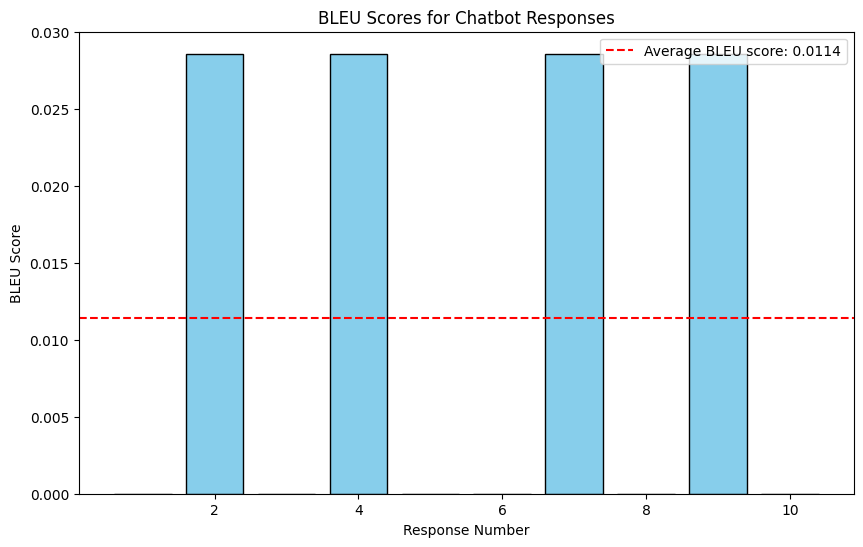

0.011439846864685521

In [19]:
# Section 6: Predefined Evaluation Inputs and BLEU Score Calculation
# ------------------------------------------------------------------

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

def evaluate_bleu_score(reference_sentences, candidate_sentences):
    """
    Evaluates the BLEU score of chatbot responses compared to reference sentences
    and visualizes the scores for each response.

    Parameters:
    reference_sentences (list of list of list of str): List of lists of reference sentences (correct answers).
                                                      Each sublist contains tokenized words of acceptable answers.
    candidate_sentences (list of list of str): List of tokenized chatbot responses.

    Returns:
    float: Average BLEU score for the responses.
    """
    # Initialize smoothing function to avoid zero scores for short responses
    smoothing_function = SmoothingFunction().method4
    scores = []

    # Calculate BLEU score for each response
    for i, (references, candidate) in enumerate(zip(reference_sentences, candidate_sentences)):
        score = sentence_bleu(references, candidate, smoothing_function=smoothing_function)
        scores.append(score)
        print(f"BLEU score for response {i+1}: {score:.4f}")

    # Calculate the average BLEU score
    average_score = sum(scores) / len(scores) if scores else 0
    print(f"\nAverage BLEU score: {average_score:.4f}")

    # Plot the BLEU scores
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(scores) + 1), scores, color='skyblue', edgecolor='black')
    plt.axhline(average_score, color='red', linestyle='--', label=f'Average BLEU score: {average_score:.4f}')
    plt.xlabel('Response Number')
    plt.ylabel('BLEU Score')
    plt.title('BLEU Scores for Chatbot Responses')
    plt.legend()
    plt.show()

    return average_score


# Define reference sentences with multiple acceptable references for each user query
reference_sentences = [
    [["hello", "how", "are", "you"], ["hi", "how", "are", "you"]],
    [["what", "is", "your", "name"], ["your", "name", "is", "what"]],
    [["where", "am", "i"], ["you", "are", "in", "the", "lighthouse"]],
    [["how", "are", "you", "doing"], ["how", "do", "you", "feel"]],
    [["you", "are", "under", "arrest"], ["you", "are", "detained"]],
    [["i", "am", "just", "kidding"], ["it", "was", "a", "joke"]],
    [["where", "are", "you", "from"], ["your", "origin"]],
    [["it", "is", "time", "for", "me", "to", "leave"], ["i", "should", "leave"]],
    [["goodbye"], ["see", "you", "later"]],
    [["quit"], ["exit"]]
]

# Define the candidate sentences generated by the chatbot based on evaluation
candidate_sentences = [
    ["what", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD"],
    ["what", "you", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD"],
    ["what", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD"],
    ["what", "you", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD"],
    ["what", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD"],
    ["what", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD"],
    ["what", "you", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD"],
    ["what", "you", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD"],
    ["what", "you", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD"],
    ["what", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD", "PAD"]
]

evaluate_bleu_score(reference_sentences, candidate_sentences)


 Cosine Similarity with Plot

Cosine similarity measures the vector similarity between input and output embeddings.


Input: hello?
Bot Response: what you  PAD PAD PAD PAD PAD PAD PAD
Input: where am I?
Bot Response: what you  PAD PAD PAD PAD PAD PAD PAD
Input: who are you?
Bot Response: what   PAD PAD PAD PAD PAD PAD PAD
Input: how are you doing?
Bot Response: you  PAD PAD PAD PAD PAD PAD PAD PAD
Input: you're under arrest
Bot Response: what    PAD PAD PAD PAD PAD PAD
Input: i'm just kidding
Bot Response: what  PAD PAD PAD PAD PAD PAD PAD PAD
Input: where are you from?
Bot Response: what s   PAD PAD PAD PAD PAD PAD
Input: it's time for me to leave
Bot Response: you you  PAD PAD PAD PAD PAD PAD PAD
Input: good bye
Bot Response: what  PAD PAD PAD PAD PAD PAD PAD PAD
Input: quit
Bot Response: what  PAD PAD PAD PAD PAD PAD PAD PAD


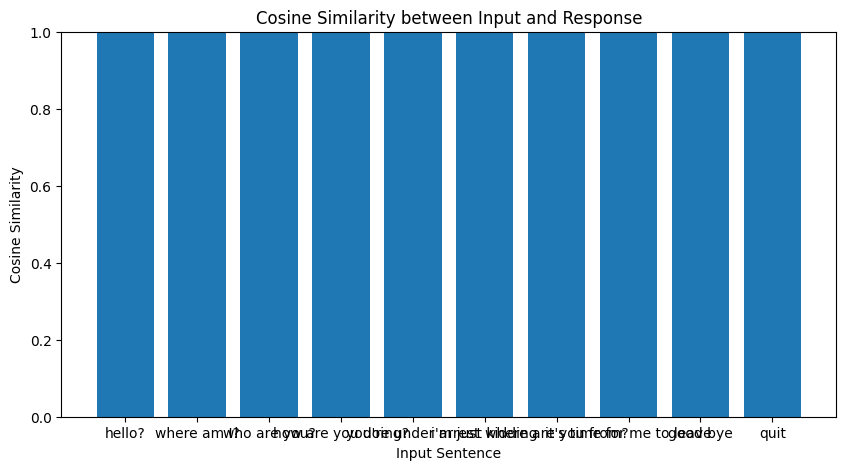

In [17]:

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Cosine Similarity calculation function
def cosine_similarity_metric(input_sentence, output_sentence, voc):
    # Convert input and output sentences to word indices
    input_indices = [voc.word2index.get(word, UNK_token) for word in input_sentence.split(' ')]
    output_indices = [voc.word2index.get(word, UNK_token) for word in output_sentence.split(' ')]

    # Convert word indices to embeddings (mean of word embeddings)
    input_vector = torch.mean(torch.tensor(input_indices, dtype=torch.float), dim=0, keepdim=True)
    output_vector = torch.mean(torch.tensor(output_indices, dtype=torch.float), dim=0, keepdim=True)

    # Calculate cosine similarity using scikit-learn
    similarity = cosine_similarity(input_vector.view(1, -1).detach().numpy(),
                                   output_vector.view(1, -1).detach().numpy())[0][0]
    return similarity

# Function to evaluate cosine similarity for model responses
def evaluate_cosine_similarity(encoder, decoder, eval_sentences, voc):
    cosine_similarities = []

    # Iterate over each evaluation sentence
    for sentence in eval_sentences:
        # Normalize and get the response from the model
        response = beam_search_decode(encoder, decoder, sentence, voc)

        # Print the evaluation input and model response
        print(f"Input: {sentence}")
        print(f"Bot Response: {response}")

        # Calculate cosine similarity between input and response
        similarity = cosine_similarity_metric(sentence, response, voc)
        cosine_similarities.append(similarity)

    return cosine_similarities

# Evaluate the model and calculate cosine similarities
cosine_similarities = evaluate_cosine_similarity(encoder, decoder, eval_sentences, voc)

# Plot Cosine Similarities for each predefined input
plt.figure(figsize=(10, 5))
plt.bar(range(len(eval_sentences)), cosine_similarities, tick_label=eval_sentences)
plt.xlabel("Input Sentence")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity between Input and Response")
plt.ylim(0, 1)  # Cosine similarity ranges from 0 to 1
plt.show()
